# Zalando Bot: AI-Powered Fashion Assistant

> Retriever - Hybrid search with Pinecone

In [ ]:
%pip install -qU pinecone
%pip install -qU pinecone-client pinecone-text pinecone-notebooks

In [1]:
import os                                   # type: ignore
import time
import pandas as pd                         # type: ignore
import matplotlib.pyplot as plt             # type: ignore
from tqdm import tqdm                       # type: ignore
from tqdm.notebook import tqdm              # type: ignore
from PIL import Image                       # type: ignore
from IPython.core.display import HTML       # type: ignore
from io import BytesIO
from base64 import b64encode

import nltk                                 # type: ignore
nltk.download('punkt_tab')

In [3]:
from pinecone import Pinecone, ServerlessSpec   # type: ignore
from pinecone_text.sparse import BM25Encoder    # type: ignore

In [4]:
import torch                                            # type: ignore
from sentence_transformers import SentenceTransformer   # type: ignore

In [5]:
from dotenv import load_dotenv              # type: ignore
load_dotenv()

True

## Load datset

In [46]:
# load the dataset
img_uri = '../data/master_data/zalando_fashionista_x300'
metadata_uri = '../data/master_data/metadata.csv'

In [47]:
metadata = pd.read_csv(metadata_uri)
metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,x100_img,x300_img
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",NaN,NaN,JAM22T04V-O14_x100.jpg,JAM22T04V-O14_x300.jpg
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",IJ022T03E-K11_x100.jpg,IJ022T03E-K11_x300.jpg
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",NaN,NaN,SU222T0VZ-M11_x100.jpg,SU222T0VZ-M11_x300.jpg
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",NaN,NaN,OM422T06R-Q11_x100.jpg,OM422T06R-Q11_x300.jpg
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",IC622T05X-Q11_x100.jpg,IC622T05X-Q11_x300.jpg


In [48]:
len(metadata)

192126

## Preprocess dataset

### Process image

In [49]:
# add x300_img image uri
metadata['img_uri'] = metadata['x300_img'].apply(lambda i: os.path.join(img_uri, i))

# drop image tags
metadata.drop(columns=['x100_img', 'x300_img'], inplace=True)

metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,img_uri
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",NaN,NaN,../data/master_data/hf_df_x300/JAM22T04V-O14_x...
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",../data/master_data/hf_df_x300/IJ022T03E-K11_x...
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",NaN,NaN,../data/master_data/hf_df_x300/SU222T0VZ-M11_x...
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",NaN,NaN,../data/master_data/hf_df_x300/OM422T06R-Q11_x...
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",../data/master_data/hf_df_x300/IC622T05X-Q11_x...


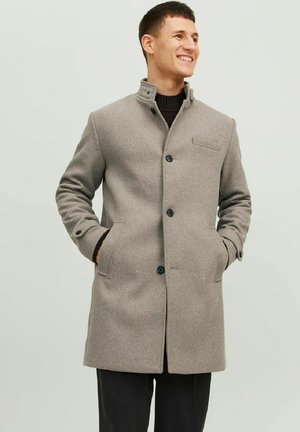

In [50]:
image = Image.open(metadata.iloc[0]['img_uri'])
image

### Process metadata

In [51]:
metadata.fillna(0, inplace=True)
metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,img_uri
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",0,0,../data/master_data/hf_df_x300/JAM22T04V-O14_x...
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",../data/master_data/hf_df_x300/IJ022T03E-K11_x...
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",0,0,../data/master_data/hf_df_x300/SU222T0VZ-M11_x...
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",0,0,../data/master_data/hf_df_x300/OM422T06R-Q11_x...
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",../data/master_data/hf_df_x300/IC622T05X-Q11_x...


In [54]:
def create_product_description(row):
    # extract the necessary columns
    sku = row['sku']
    name = row['name']
    brand = row['brand']
    category = row['category']
    url = row['url']
    sizes = row['sizes']
    classification = row['classification']
    original_price = row['original_price']
    discount_percentage = row['discount_percentage']
    promotional_price = row['promotional_price']

    # add SKU (if relevant for your use case)
    description = f"SKU: {sku}.\n"

    # start building the description
    description += f"Product Name: {name} by {brand}.\n"
    description += f"Category: {category}. Status: {classification}.\n"

    # add available sizes, if present
    if pd.notna(sizes):
        description += f"Available Sizes: {sizes}.\n"
    
    # add price and promotional information
    if pd.notna(original_price) and pd.notna(promotional_price) and original_price != 0 and promotional_price != 0:
        description += f"Original Price: {original_price}, now available for {promotional_price}.\n"
        if pd.notna(discount_percentage) and discount_percentage != 0:
            description += f"Discount: {discount_percentage} off.\n"
    elif pd.notna(original_price) and original_price != 0:
        description += f"Price: {original_price}.\n"
    
    # add URL for reference
    description += f"More details can be found at: {url}.\n"   
    
    return description

In [55]:
metadata['description'] = metadata.apply(create_product_description, axis=1)
metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,img_uri,description
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",0,0,../data/master_data/hf_df_x300/JAM22T04V-O14_x...,SKU: JAM22T04V-O14.\nProduct Name: BLAMELTON S...
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",../data/master_data/hf_df_x300/IJ022T03E-K11_x...,SKU: IJ022T03E-K11.\nProduct Name: Parka - nav...
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",0,0,../data/master_data/hf_df_x300/SU222T0VZ-M11_x...,SKU: SU222T0VZ-M11.\nProduct Name: Winter coat...
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",0,0,../data/master_data/hf_df_x300/OM422T06R-Q11_x...,SKU: OM422T06R-Q11.\nProduct Name: Short coat ...
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",../data/master_data/hf_df_x300/IC622T05X-Q11_x...,SKU: IC622T05X-Q11.\nProduct Name: CLIMA IGLU ...


In [59]:
metadata.iloc[0]['description'], metadata.iloc[1]['description'], metadata.iloc[100]['description']

("SKU: JAM22T04V-O14.\nProduct Name: BLAMELTON SN - Short coat - greige by Jack & Jones PREMIUM.\nCategory: ['Coats']. Status: [].\nAvailable Sizes: [{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}, {'size': 'M', 'sku': 'JAM22T04V-O14000M000'}, {'size': 'L', 'sku': 'JAM22T04V-O14000L000'}, {'size': 'XL', 'sku': 'JAM22T04V-O1400XL000'}, {'size': 'XXL', 'sku': 'JAM22T04V-O140XXL000'}].\nPrice: 149,99\xa0€.\nMore details can be found at: https://en.zalando.de/jack-and-jones-premium-jprblamelton-classic-coat-greige-jam22t04v-o14.html.\n",
 "SKU: IJ022T03E-K11.\nProduct Name: Parka - navy by INDICODE JEANS.\nCategory: ['Coats']. Status: ['DEAL'].\nAvailable Sizes: [{'size': 'S', 'sku': 'IJ022T03E-K11000S000'}, {'size': 'M', 'sku': 'IJ022T03E-K11000M000'}, {'size': 'XL', 'sku': 'IJ022T03E-K1100XL000'}, {'size': 'XXL', 'sku': 'IJ022T03E-K110XXL000'}].\nOriginal Price: 114,99\xa0€, now available for 104,99\xa0€.\nDiscount: up to -9% off.\nMore details can be found at: https://en.zalando.de/indic

## Connect to Pinecorn

In [60]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

In [61]:
index_name = "zalando-query-retriever"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,
        metric="dotproduct",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        ) 
    )

    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)

# view index stats
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Sparse Vectors

In [62]:
bm25 = BM25Encoder()

In [63]:
bm25.fit(metadata['description'])

  0%|          | 0/192126 [00:00<?, ?it/s]

In [64]:
metadata.iloc[0]['description']

"SKU: JAM22T04V-O14.\nProduct Name: BLAMELTON SN - Short coat - greige by Jack & Jones PREMIUM.\nCategory: ['Coats']. Status: [].\nAvailable Sizes: [{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}, {'size': 'M', 'sku': 'JAM22T04V-O14000M000'}, {'size': 'L', 'sku': 'JAM22T04V-O14000L000'}, {'size': 'XL', 'sku': 'JAM22T04V-O1400XL000'}, {'size': 'XXL', 'sku': 'JAM22T04V-O140XXL000'}].\nPrice: 149,99\xa0€.\nMore details can be found at: https://en.zalando.de/jack-and-jones-premium-jprblamelton-classic-coat-greige-jam22t04v-o14.html.\n"

In [65]:
bm25.encode_queries(metadata.iloc[0]['description'])

{'indices': [2678883381,
  2963255504,
  3476647774,
  3685696496,
  186221821,
  1737701096,
  883390095,
  678506946,
  737742514,
  3325854957,
  4059223789,
  3319279674,
  308817224,
  3394423989,
  1362116887,
  3985184762,
  2005296794,
  76540501,
  3534898626,
  1839152771,
  492661292,
  1375280964,
  3909507060,
  2399391443,
  3875592032,
  2500167652,
  3888873998,
  1930065484,
  1531182245,
  569047032,
  1810936627,
  3800896210,
  2472411037],
 'values': [1.93015480808542e-08,
  0.08722355753453602,
  1.93015480808542e-08,
  1.93015480808542e-08,
  0.07528685963955975,
  0.05247479807434381,
  0.02166361417627323,
  0.018897289992079798,
  0.06335016174458347,
  0.02991629264429432,
  0.031970083701487295,
  0.022906250203269047,
  1.93015480808542e-08,
  1.93015480808542e-08,
  1.93015480808542e-08,
  1.93015480808542e-08,
  0.008951216638573295,
  0.08722355753453602,
  0.005166765207596239,
  0.08722355753453602,
  0.005218076635051749,
  0.08722355753453602,
  0.00

## Dence Vectors

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

Device:  cuda


/mnt/d/vault/devhub/zalando_query_bot/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


SentenceTransformer(
  (0): CLIPModel()
)

## Upsert Documents

In [67]:
# define the batch size
batch_size = 200

# initialize an empty list to store items
items = []

# iterate over the rows in the DataFrame
for idx, row in tqdm(metadata.iterrows()):
    # generate a unique ID
    id = row['sku']

    # create a dictionary of metadata
    meta_dict = row.to_dict()

    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_queries(row['description'])

    # create dense vectors from the image URI
    dense_embeds = model.encode(row['img_uri'])

    # append the item dictionary to the items list
    items.append({
        'id': id,
        'sparse_values': sparse_embeds,
        'values': dense_embeds,
        'metadata': meta_dict
    })

    # if the number of items reaches the batch size, upload the batch
    if len(items) >= batch_size:
        # upsert the current batch of items to the index
        index.upsert(items)
        
        # clear the items list to prepare for the next batch
        items.clear()

# after the loop, if there are any remaining items, upload them
if items:
    index.upsert(items)

# show the index description after uploading the documents
index.describe_index_stats()

0it [00:00, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 192126}},
 'total_vector_count': 192126}

## Hybrid search

In [84]:


# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()  
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

### Method - 1


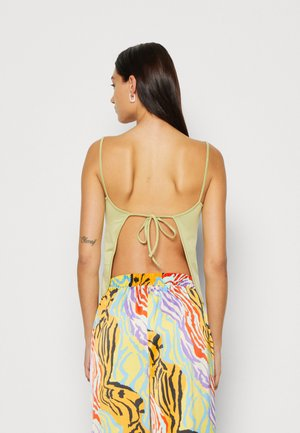
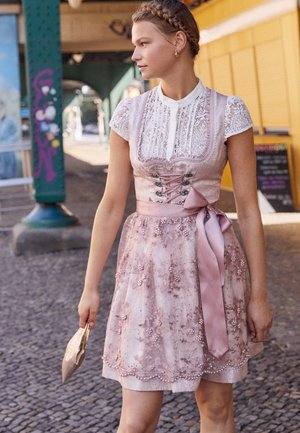
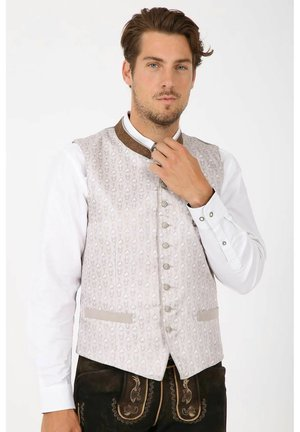
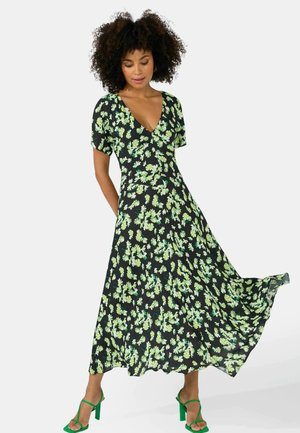
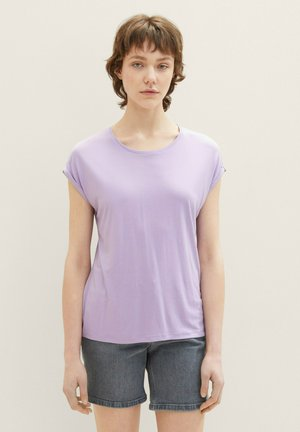

In [99]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# search
result = index.query(
    top_k=5,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = []
garments = [item['id'] for item in result['matches']]
for garment in garments:
    img = Image.open(metadata[metadata['sku']==garment]['img_uri'].values[0])
    imgs.append(img)

display_result(imgs)

### Method - 2

In [86]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse


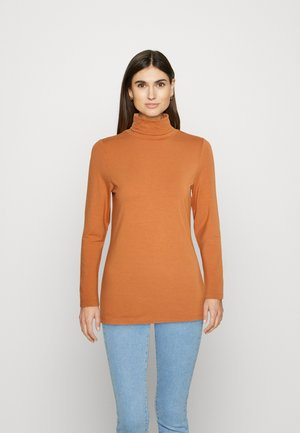
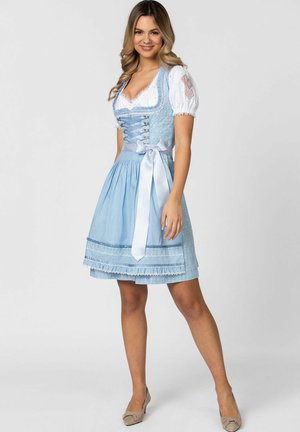
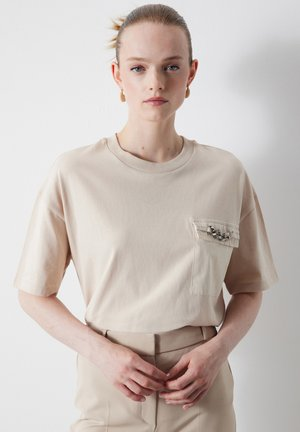
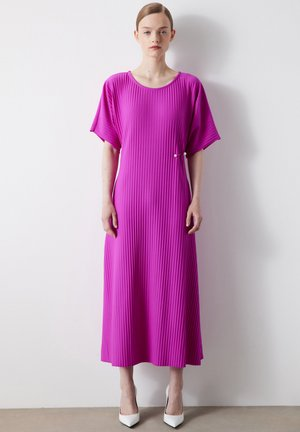
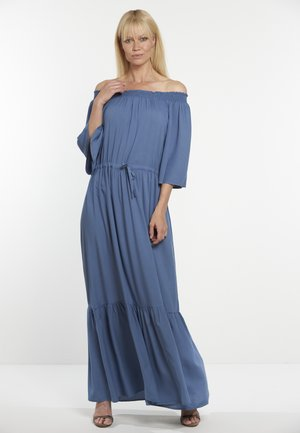

In [103]:
query = "soft purple topwear"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)

# search
result = index.query(
    top_k=5,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = []
garments = [item['id'] for item in result['matches']]
for garment in garments:
    img = Image.open(metadata[metadata['sku']==garment]['img_uri'].values[0])
    imgs.append(img)

display_result(imgs)

## Delete the Index

In [104]:
pc.delete_index(index_name)